<a href="https://colab.research.google.com/github/bindhu0404/BrainTumorDetector-CNN/blob/main/BrainTumorrrrrrrrr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget https://www.dropbox.com/scl/fi/4q4ezdn1busmmiftomd2m/archive.zip?rlkey=st0caljrmbvz5mlzczrp1r0ml&st=scvef52f&dl=0

--2025-02-01 16:35:22--  https://www.dropbox.com/scl/fi/4q4ezdn1busmmiftomd2m/archive.zip?rlkey=st0caljrmbvz5mlzczrp1r0ml
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8b451647b75ca6afa5a3cc92e2.dl.dropboxusercontent.com/cd/0/inline/CjTFV6m5mufTPnDTCuzR15XsHk3SrSiol9j_1b9HcQXTjSsQUf7oXIjv_DN5YhxCwy3BYLZyvti8oTxfsmv36NmlZgaAlodJVwmqmKnF2eK0GiUzYmMsVH2FsUvb2KeVaV8LbgZji4XJHwoj2Xt3Z5iI/file# [following]
--2025-02-01 16:35:22--  https://uc8b451647b75ca6afa5a3cc92e2.dl.dropboxusercontent.com/cd/0/inline/CjTFV6m5mufTPnDTCuzR15XsHk3SrSiol9j_1b9HcQXTjSsQUf7oXIjv_DN5YhxCwy3BYLZyvti8oTxfsmv36NmlZgaAlodJVwmqmKnF2eK0GiUzYmMsVH2FsUvb2KeVaV8LbgZji4XJHwoj2Xt3Z5iI/file
Resolving uc8b451647b75ca6afa5a3cc92e2.dl.dropboxusercontent.com (uc8b451647b75ca6afa5a3cc92e2.dl.dropboxusercontent.com)... 162.125.5.15, 2620:10

In [ ]:
!unzip /content/archive.zip?rlkey=st0caljrmbvz5mlzczrp1r0ml

Archive:  /content/archive.zip?rlkey=st0caljrmbvz5mlzczrp1r0ml
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_

Import required Libraries

In [ ]:
import os
import numpy as np
import cv2
import math
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
import matplotlib.pyplot as plt


Define Paths & Create Augmented Dataset

In [ ]:
ROOT_DIR = "/content/brain_tumor_dataset"
AUGMENTED_DIR = "/content/brain_tumor_dataset_augmented"


In [ ]:
for category in ["Brain_Tumor", "Healthy"]:
    os.makedirs(os.path.join(AUGMENTED_DIR, category), exist_ok=True)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Augment & Save Images

In [ ]:
def augment_images(category, num_augmentations=5):
    source_dir = os.path.join(ROOT_DIR, category)
    target_dir = os.path.join(AUGMENTED_DIR, category)

    images = os.listdir(source_dir)
    for img_name in tqdm(images, desc=f"Augmenting {category}"):
        img_path = os.path.join(source_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = np.expand_dims(img, axis=0)


        i = 0
        for batch in datagen.flow(img, batch_size=1):
            new_img_name = f"aug_{i}_{img_name}"
            new_img_path = os.path.join(target_dir, new_img_name)
            cv2.imwrite(new_img_path, cv2.cvtColor(batch[0], cv2.COLOR_RGB2BGR))
            i += 1
            if i >= num_augmentations:
                break


In [ ]:
augment_images("BrainTumor", num_augmentations=5)
augment_images("Healthy", num_augmentations=10)

print("✅ Dataset Augmentation Completed!")

Augmenting Healthy: 100%|██████████| 155/155 [00:23<00:00,  6.53it/s]

✅ Dataset Augmentation Completed!


Split Data into Train, Validation, and Test Sets

In [ ]:
def split_data(source, train_ratio=0.7, val_ratio=0.15):
    categories = ["BrainTumor", "Healthy"]
    for category in categories:
        img_list = os.listdir(os.path.join(source, category))
        np.random.shuffle(img_list)

        train_count = int(train_ratio * len(img_list))
        val_count = int(val_ratio * len(img_list))

        sets = {
            "train": img_list[:train_count],
            "val": img_list[train_count:train_count + val_count],
            "test": img_list[train_count + val_count:]
        }

        for folder, imgs in sets.items():
            folder_path = f"/content/dataset/{folder}/{category}"
            os.makedirs(folder_path, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(source, category, img), folder_path)


In [ ]:
split_data(AUGMENTED_DIR)

print(" Data Splitting Completed!")

✅ Data Splitting Completed!


Load Data for Training

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_datagen.flow_from_directory(
    "/content/dataset/train", target_size=(224, 224), batch_size=32, class_mode="binary"
)

Found 2109 images belonging to 2 classes.


In [ ]:
val_data = val_test_datagen.flow_from_directory(
    "/content/dataset/val", target_size=(224, 224), batch_size=32, class_mode="binary"
)

Found 644 images belonging to 2 classes.


In [ ]:
test_data = val_test_datagen.flow_from_directory(
    "/content/dataset/test", target_size=(224, 224), batch_size=32, class_mode="binary"
)

Found 640 images belonging to 2 classes.


Define CNN Model

In [ ]:
# ✅ Define Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])




In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
mc = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy")

Train the Model

In [ ]:
history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[es, mc])

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6356 - loss: 0.6803

66/66 ━━━━━━━━━━━━━━━━━━━━ 287s 4s/step - accuracy: 0.6362 - loss: 0.6792 - val_accuracy: 0.7003 - val_loss: 0.5534
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7444 - loss: 0.5068

66/66 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.7441 - loss: 0.5073 - val_accuracy: 0.7143 - val_loss: 0.5365
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - accuracy: 0.7166 - loss: 0.5265 - val_accuracy: 0.7127 - val_loss: 0.5598
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7664 - loss: 0.4856

66/66 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.7665 - loss: 0.4855 - val_accuracy: 0.7655 - val_loss: 0.4721
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.7888 - loss: 0.4475 - val_accuracy: 0.7252 - val_loss: 0.5577
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7609 - loss: 0.4793

66/66 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.7612 - loss: 0.4789 - val_accuracy: 0.7826 - val_loss: 0.4560
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8207 - loss: 0.3982

66/66 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.8206 - loss: 0.3984 - val_accuracy: 0.8199 - val_loss: 0.4180
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.8124 - loss: 0.4070 - val_accuracy: 0.8168 - val_loss: 0.4127
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8495 - loss: 0.3383

66/66 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.8493 - loss: 0.3387 - val_accuracy: 0.8494 - val_loss: 0.3786
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8579 - loss: 0.3333

66/66 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.8580 - loss: 0.3331 - val_accuracy: 0.8602 - val_loss: 0.3479
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8944 - loss: 0.2620

66/66 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.8943 - loss: 0.2622 - val_accuracy: 0.8696 - val_loss: 0.3346
Epoch 12/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9141 - loss: 0.2347

66/66 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.9139 - loss: 0.2348 - val_accuracy: 0.8898 - val_loss: 0.3207
Epoch 13/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8929 - loss: 0.2486

66/66 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.8930 - loss: 0.2483 - val_accuracy: 0.9161 - val_loss: 0.2694
Epoch 14/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.9246 - loss: 0.1817 - val_accuracy: 0.8960 - val_loss: 0.2737
Epoch 15/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9395 - loss: 0.1491

66/66 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.9395 - loss: 0.1492 - val_accuracy: 0.9208 - val_loss: 0.2565
Epoch 16/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.9558 - loss: 0.1294 - val_accuracy: 0.9115 - val_loss: 0.2963
Epoch 17/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9563 - loss: 0.1109

66/66 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.9565 - loss: 0.1109 - val_accuracy: 0.9441 - val_loss: 0.2517
Epoch 18/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.9625 - loss: 0.1076 - val_accuracy: 0.9379 - val_loss: 0.2750
Epoch 19/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.9671 - loss: 0.0827 - val_accuracy: 0.9394 - val_loss: 0.3215
Epoch 20/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.9691 - loss: 0.0870 - val_accuracy: 0.9363 - val_loss: 0.2919


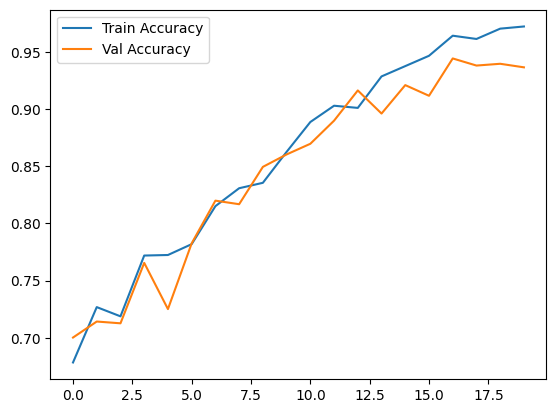

In [ ]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.show()

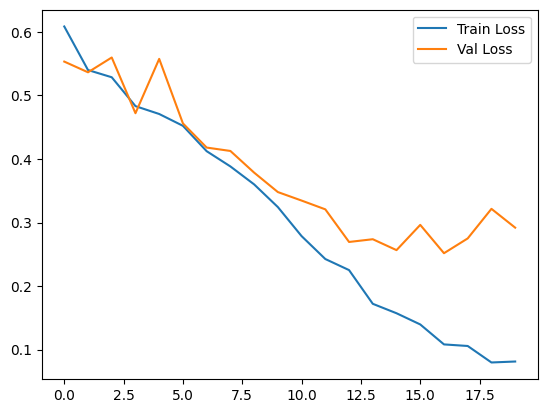

In [ ]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

In [ ]:
model.load_weights("best_model.h5")

Evaluate Model on Test Data

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Model Test Accuracy: {test_acc * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9381 - loss: 0.2542
✅ Model Test Accuracy: 94.22%


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


def predict_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]

    if prediction < 0.5:
        print("🔴 The MRI has a Brain Tumor")
    else:
        print("🟢 The MRI is Healthy")


predict_image("/content/Screenshot (545).png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
🔴 The MRI has a Brain Tumor
